## Assignment 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [2]:
# In colab run this cell
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/utils.py -nc
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/features.py -nc

Файл «utils.py» уже существует — не загружается.

Файл «features.py» уже существует — не загружается.



In [3]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

--2021-03-17 13:28:43--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/comments_small_dataset/comments.tsv
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 353358 (345K) [text/plain]
Сохранение в: «comments.tsv»

comments.tsv        100%[===================>] 345,08K  --.-KB/s    за 0,1s    

2021-03-17 13:28:44 (2,62 MB/s) - «comments.tsv» сохранён [353358/353358]



In [4]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [ ]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk

# nltk.download('stopwords')
# split a given sentence into words
# keeps hashtags intact (that's why do not use word_tokenize)
tokenizer = TweetTokenizer()
stop_words = stopwords.words('english')
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [8]:
def normalize_text(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-ZА-я\s\d]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = tokenizer.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [10]:
# task: preprocess each comment in train and test
import re

texts_train = np.array([normalize_text(text) for text in texts_train])
texts_test = np.array([normalize_text(text) for text in texts_test])

**NB: As I have changed the preprocessing pipeline, these default asserts do not make sense**

In [12]:
texts_train[5]

'cares anymore attack impunity'

In [14]:
# Small check that everything is done properly
# assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
# assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [17]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))
print('unique words:', k)

all_words = np.array(' '.join(texts_train).split())
print('all words:', all_words.shape[0])

u, count = np.unique(all_words, return_counts=True)
count_sort_ind = np.argsort(count)
print(count_sort_ind)

bow_vocabulary = u[count_sort_ind][:k]

print('example features:', sorted(bow_vocabulary)[::100])
print(bow_vocabulary.shape)

unique words: 5389
all words: 19311
[4891 2792 2793 ... 2346 2395 4632]
example features: ['!', '184', '4ever', 'acrs', 'al', 'appealing', 'attempted', 'beforehand', 'bon', 'cache', 'chavez', 'cocksucking', 'consider', 'cow', 'death', 'detract', 'ditch', 'educational', 'especially', 'fact', 'finn', 'front', 'glow', 'hanibal', 'hoax', 'imperial', 'insulted', 'joa', 'lake', 'line', 'makedonski', 'merging', 'moukity', 'nicaragua', 'offer', 'particularly', 'pillars', 'precise', 'proved', 'reach', 'remarks', 'revisions', 'saved', 'shameful', 'slav', 'sphere', 'studies', 'system', 'thermonuclear', 'tower', 'uncommon', 'vandalising', 'watford', 'worked']
(5389,)


In [19]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    bag_vector = np.zeros(len(bow_vocabulary))
    
    for w in text.split():
        for i, word in enumerate(bow_vocabulary):
            if w == word:
                bag_vector[i] += 1

    return np.array(bag_vector, 'float32')

In [20]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [57]:
np.where(bow_vocabulary == '.')[0][0]

4779

In [59]:
list(bow_vocabulary).index('.')

4779

In [58]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, np.where(bow_vocabulary == '.')[0][0]] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [60]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

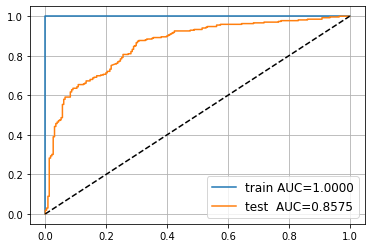

In [61]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [62]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [63]:
from utils import plot_train_process

In [66]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(X_train_bow.shape[1], 2))
model.add_module('l2', nn.Sigmoid())

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [67]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [68]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

In [69]:
X_train_bow_torch = torch.tensor(X_train_bow)
X_test_bow_torch = torch.tensor(X_test_bow)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

Let's test that everything is fine

In [70]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [71]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [72]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

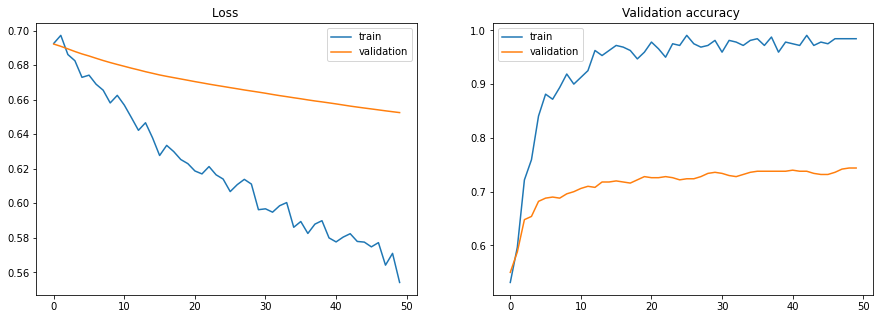

Sequential(
  (l1): Linear(in_features=5389, out_features=2, bias=True)
  (l2): Sigmoid()
)

In [75]:
scheduler = StepLR(opt, step_size=100, gamma=0.1)
train_model(model, opt, scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

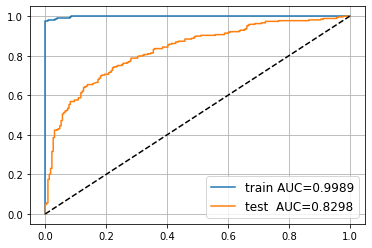

In [76]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [77]:
# Your beautiful code here

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [78]:
from features import TfIdf
import math

def computeReviewTFDict(review):
    """ Returns a tf dictionary for each review whose keys are all
    the unique words in the review and whose values are their
    corresponding tf.
    """
    # Counts the number of times the word appears in review
    reviewTFDict = {}
    for word in review.split():
        if word in reviewTFDict:
            reviewTFDict[word] += 1
        else:
            reviewTFDict[word] = 1
            
    # Computes tf for each word
    for word in reviewTFDict:
        reviewTFDict[word] = reviewTFDict[word] / len(review)
    return reviewTFDict

In [79]:
def computeReviewTFIDFDict(reviewTFDict, idfDict):
    """ Returns a dictionary whose keys are all the unique words in the
    review and whose values are their corresponding tfidf.
    """
    reviewTFIDFDict = {}
    #For each word in the review, we multiply its tf and its idf.
    for word in reviewTFDict:
        reviewTFIDFDict[word] = reviewTFDict[word] * idfDict[word] if word in idfDict else 0
    return reviewTFIDFDict

In [80]:
def computeTFIDFVector(review, wordDict):
    tfidfVector = [0.0] * len(wordDict)

    # For each unique word, if it is in the review, store its TF-IDF value.
    for i, word in enumerate(wordDict):
        if word in review:
            tfidfVector[i] = review[word]
    return tfidfVector

In [81]:
def computeTfIDFMatrix(train_data, test_data):
    tfDict = [computeReviewTFDict(text) for text in train_data] 
    
    countDict = {}
    # Run through each review's tf dictionary and increment countDict's (word, doc) pair
    for review in tfDict:
        for word in review:
            if word in countDict:
                countDict[word] += 1
            else:
                countDict[word] = 1
                
    idfDict = {}
    for word in countDict:
        idfDict[word] = math.log(len(data) / countDict[word])
    
    tfidfDict = [computeReviewTFIDFDict(review, idfDict) for review in tfDict]
    
    wordDict = sorted(countDict.keys())
    
    tfidfVector = [computeTFIDFVector(review, wordDict) for review in tfidfDict]
    
    # transform test set
    tfDictTest = [computeReviewTFDict(text) for text in test_data]
    
    idfDictTest = {}
    for word in countDict:
        idfDictTest[word] = math.log(len(data) / countDict[word])
    
    tfidfDictTest = [computeReviewTFIDFDict(review, idfDict) for review in tfDictTest]
    tfidfVectorTest = [computeTFIDFVector(review, wordDict) for review in tfidfDictTest]
    
    return tfidfVector, tfidfVectorTest

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [82]:
X_train_tfidf, X_test_tfidf = computeTfIDFMatrix(texts_train, texts_test)
tfidf_model = LogisticRegression().fit(X_train_tfidf, y_train)

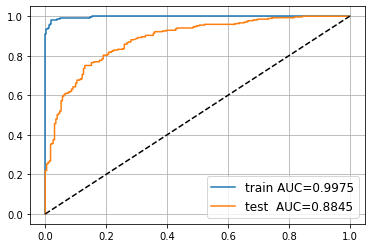

In [83]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, tfidf_model),
    ('test ', X_test_tfidf, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

#### Compare with sklearn implementation

(500, 4500)
(500, 4500)


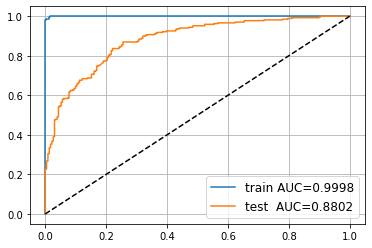

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=4500)
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

print(X_train.shape)
print(X_test.shape)

tfidf_model_sklearn = LogisticRegression().fit(X_train, y_train)

for name, X, y, model in [
    ('train', X_train, y_train, tfidf_model_sklearn),
    ('test ', X_test, y_test, tfidf_model_sklearn)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

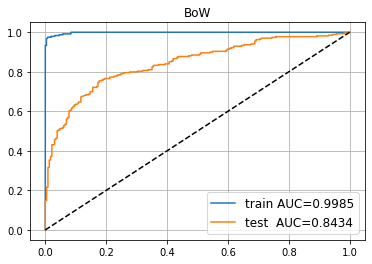

In [87]:
from sklearn.naive_bayes import MultinomialNB

gnb_bow = MultinomialNB()
gnb_bow = gnb_bow.fit(X_train_bow, y_train)

for name, X, y in [
    ('train', X_train_bow, y_train),
    ('test ', X_test_bow, y_test)
]:
    proba = gnb_bow.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.title('BoW')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

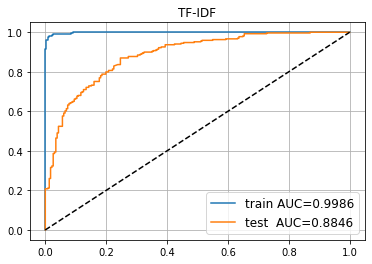

In [88]:
gnb_tfidf = MultinomialNB()
gnb_tfidf = gnb_tfidf.fit(X_train_tfidf, y_train)

for name, X, y in [
    ('train', X_train_tfidf, y_train),
    ('test ', X_test_tfidf, y_test)
]:
    proba = gnb_tfidf.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.title('TF-IDF')
plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

**As we can see, the tf-idf model is a little bit better!**

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [90]:
from gensim.models import Word2Vec
import gensim.downloader as api
import multiprocessing
from time import time

In [91]:
texts_train_split = [text.split() for text in texts_train]

In [92]:
# we could train our own w2v model like this:
# nlp = Word2Vec(texts_train_split, size=300, window=8, min_count=25, sg=1, iter=30)
# N = 300

In [93]:
nlp = api.load('glove-twitter-25')
N = 25

[==================================================] 100.0% 104.8/104.8MB downloaded


In [104]:
matrix_train = []
for text in texts_train:
    mean = np.zeros(N)
    for word in text.split():
        size = 0
        if word in nlp.wv:
            mean += nlp.wv[word]
            size += 1
    if size != 0:
        mean /= size
    matrix_train.append(mean)
matrix_train = np.array(matrix_train)

<ipython-input-104-1decd56ea59a>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in nlp.wv:
<ipython-input-104-1decd56ea59a>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  mean += nlp.wv[word]


In [99]:
matrix_train.shape

(500, 25)

In [101]:
matrix_test = []
for text in texts_test:
    mean = np.zeros(N)
    for word in text.split():
        size = 0
        if word in nlp.wv:
            mean += nlp.wv[word]
            size += 1
    if size != 0:
        mean /= size
    matrix_test.append(mean)
matrix_test = np.array(matrix_test)

<ipython-input-101-8b48377e0d96>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in nlp.wv:
<ipython-input-101-8b48377e0d96>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  mean += nlp.wv[word]


In [105]:
matrix_test.shape

(500, 25)

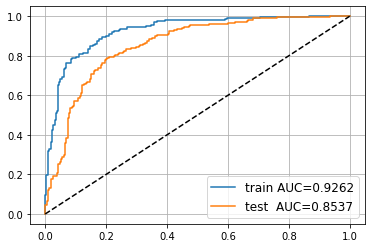

In [106]:
model_w2v = LogisticRegression(max_iter=1000).fit(matrix_train, y_train)

for name, X, y, model in [
    ('train', matrix_train, y_train, model_w2v),
    ('test ', matrix_test, y_test, model_w2v)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

**In my opinion, results are all great, but can be improved!**